# **Fares Ahmed Moustafa**
### ***F.ahmed2270@nu.edu.eg***

In [25]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

## ***Downloading the AAPL Dataset***
the daily Adjusted Close Price of Apple Inc. (AAPL) from Yahoo Finance, spanning 2015–2025. This series is widely used in financial forecasting research, provides over 10 years of high-quality historical data, and is suitable for modeling with neural architectures such as LSTM.

In [5]:
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end=None, progress=False)

df = df[['Close']].rename(columns={'Close': 'adj_close'})

print(df.head())
print(df.tail())
print("Total rows:", len(df))
print("Date range:", df.index.min(), "to", df.index.max())

df.to_csv("AAPL_adj_close.csv")

/tmp/ipython-input-2335880701.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end=None, progress=False)


Price       adj_close
Ticker           AAPL
Date                 
2015-01-02  24.237549
2015-01-05  23.554741
2015-01-06  23.556950
2015-01-07  23.887278
2015-01-08  24.805086
Price        adj_close
Ticker            AAPL
Date                  
2025-11-10  269.429993
2025-11-11  275.250000
2025-11-12  273.470001
2025-11-13  272.950012
2025-11-14  272.410004
Total rows: 2735
Date range: 2015-01-02 00:00:00 to 2025-11-14 00:00:00


In [12]:
df.head()

Price,adj_close
Ticker,AAPL
Date,
2015-01-02,24.237549
2015-01-05,23.554741
2015-01-06,23.556950
2015-01-07,23.887278
2015-01-08,24.805086


### ***Data Cleaning***

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2735 entries, 2015-01-02 to 2025-11-14
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (adj_close, AAPL)  2735 non-null   float64
dtypes: float64(1)
memory usage: 42.7 KB


In [19]:
df.describe()

Price,adj_close
Ticker,AAPL
count,2735.000000
mean,104.411254
std,72.520537
min,20.604074
25%,36.452194
50%,81.457993
75%,167.275108
max,275.250000


In [ ]:
n = len(df)
train_end = int(n * 0.7)   
val_end   = int(n * 0.85)  

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

scaler = MinMaxScaler()
scaler.fit(train_df[['adj_close']])

train_scaled = scaler.transform(train_df[['adj_close']])
val_scaled   = scaler.transform(val_df[['adj_close']])
test_scaled  = scaler.transform(test_df[['adj_close']])

X_train, y_train = create_sequences(train_scaled, T)
X_val, y_val     = create_sequences(val_scaled, T)
X_test, y_test   = create_sequences(test_scaled, T)

In [ ]:
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

T = 60

X_train, y_train = create_sequences(train_scaled, T)
X_val,   y_val   = create_sequences(val_scaled,   T)
X_test,  y_test  = create_sequences(test_scaled,  T)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0],   X_val.shape[1],   1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1854, 60, 1), (1854,), (350, 60, 1), (350,), (351, 60, 1), (351,))

## ***LSTM Modeling***

In [23]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(T, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
EPOCHS = 75
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4333e-04 - val_loss: 3.8884e-04
Epoch 2/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3033e-04 - val_loss: 3.1691e-04
Epoch 3/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1056e-04 - val_loss: 3.1008e-04
Epoch 4/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9234e-04 - val_loss: 2.6539e-04
Epoch 5/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0590e-04 - val_loss: 0.0010
Epoch 6/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.5185e-04 - val_loss: 4.9422e-04
Epoch 7/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3538e-04 - val_loss: 4.0356e-04
Epoch 8/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0928e-04 - val_loss: 5.3113e-04
Epoch 9/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6543e-04 - val_loss: 0.0015
Epoch 10/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4426e-04 - val_loss: 3.4503e-04
Epoch 11/75
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9643e-04 - val_loss

## ***Model Evaluation***

In [38]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.4f}%")
print(f"R²   = {r2:.4f}")

MAE  = 4.1187
RMSE = 5.2064
MAPE = 1.9682%
R²   = 0.9597


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model Evaluation Metrics:
MAE  = 4.1187
RMSE = 5.2064


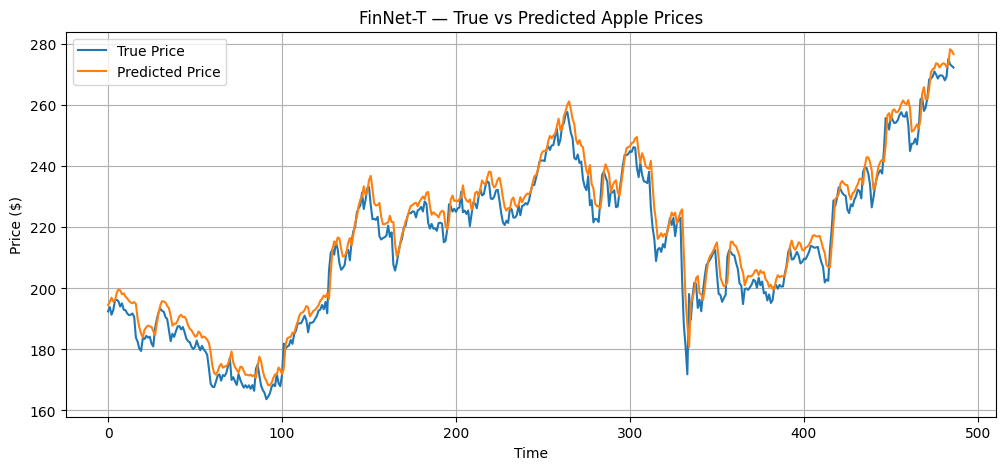

In [28]:
y_pred_scaled = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("Model Evaluation Metrics:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

plt.figure(figsize=(12,5))
plt.plot(y_true, label='True Price')
plt.plot(y_pred, label='Predicted Price')
plt.title("FinNet-T — True vs Predicted Apple Prices")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

## ***Report***
The LSTM model demonstrates strong predictive ability, capturing the overall upward trend in AAPL’s stock price and successfully following major turning points in the test period. Although the predictions track the direction of movement well, they show a slight lag, which is expected in sequence-based models because predictions depend on historical data. In real-time trading, this lag can reduce the model’s usefulness, as traders require early signals rather than delayed confirmations. From a risk perspective, the RMSE of approximately $5.21 indicates that a typical prediction may be off by about five dollars. For a highly liquid stock like AAPL, this level of uncertainty represents meaningful financial exposure when executing large positions, highlighting that the model is suitable for trend forecasting, but not for precise short-term trading decisions.